   <h1>                                   Business Problem </h1>
  
  
  <h3>Domain: Insurance</h3>
  
  <br>
  1. Predict whether the customer will renew the insurance or not.<br> <br>
  2. Calculate how much commision should be paid to agent to maximize the revenue.<br>
  
  
  <h2>1. Predicting the Renewal of Insurance <h2>

In [153]:
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

from hyperopt import hp

import numpy as np

from sklearn.metrics import mean_squared_error

import hyperopt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import xgboost as xgb

from xgboost.sklearn import XGBRegressor

from sklearn.metrics import accuracy_score

from sklearn import metrics

from hyperopt import space_eval

from sklearn.metrics import confusion_matrix,classification_report,f1_score,accuracy_score,roc_auc_score

from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error

from math import exp

import scipy.optimize as op

import shap


<h3>1.1 Preprocessing Function </h3>

Created function ohe where we have used ONE HOT ENCODER for preprocessing of categorical features

In [154]:
def ohe(column_list,X_train):

    ohe=OneHotEncoder(handle_unknown='ignore')
    
    ohe_train=ohe.fit_transform(X_train[column_list])
    
    cat_cols=pd.DataFrame(ohe_train.toarray(),columns=ohe.get_feature_names())
    
    return cat_cols,ohe

<h3> 1.2 Tuning the Hyperparameters </h3>


<h4>1.2.1 Defining Objective Function </h4><br>
Created function objective_function to minimize loss for given set of hyperparameters.

In [155]:
def objective_function(params):
    
    X=params['X']
    y=params['y']
    n=params['fold']
    
    del params['X']
    del params['y']
    
    F1_Score=0
    
    for i in range(n):
    
        X_train, X_test,y_train, y_test=train_test_split (X,y, random_state=i*2,stratify=y,test_size=0.1)
    
        clf=xgb.XGBClassifier(**params)
    
        evaluation = [( X_train, y_train), ( X_test, y_test)]
    
        clf.fit(X_train, y_train,
            eval_set=evaluation,
            early_stopping_rounds=20,verbose=False)

        pred = clf.predict(X_test)
        #f1=f1_score(pred,y_test,average='macro')
        f1=f1_score(pred,y_test)
        acc=accuracy_score(pred,y_test)
    #    print(f1)
        F1_Score += (f1+acc)/2
        
    print ("ACCURACY:", acc)
    #change the metric if you like
    if F1_Score>1 or F1_Score<0:
        
        return {'loss': np.inf, 'status': STATUS_OK }
    
    else:
        
        return {'loss': -F1_Score/n, 'status': STATUS_OK }


<h4>1.2.2 Define the Search Space of the Hyperparameters</h4>
<br>
Created function tune_param for hyperparameter tuning using Bayesian optimisation by implementing hyperopt which gives us the best parameters for our model

In [156]:
def tune_params(X_train,y_train):
    
    space={'max_depth':  hp.choice('max_depth', np.arange(3, 18, dtype=int)),
        'gamma': hp.uniform ('gamma', 0,20),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,10),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.3,0.9),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform("n_estimators",30,500,10),
        'learning_rate':hp.quniform('learning_rate',0.02,0.9,0.01),
        'scale_pos_weight':hp.uniform('scale_pos_weight',0.03,5),
           'base_score':hp.uniform('base_score',0,1),
           'colsample_bylevel':hp.uniform('colsample_bylevel',0.5,1),
           'colsample_bynode':hp.uniform('colsample_bynode',0.5,1),
        'X':X_train,
        'fold':1,
        'y':y_train
    }




    trials = Trials()
    best_param = fmin(objective_function,space=space, algo=tpe.suggest,
                      max_evals=40, trials=trials)
    
    
    return space_eval(space, best_param)


In [ ]:
train = pd.read_excel ('/Users/shrutijain/Desktop/ING/train.xlsx', index_col=0).dropna()

X = train.loc[:, train.columns != 'renewal']

y=train['renewal'].values

ohe_features,encoder=ohe(['sourcing_channel','residence_area_type'],X)

X=X.reset_index(drop=True)

X=pd.concat([X,ohe_features],axis=1)

X=X.drop(['sourcing_channel','residence_area_type'], axis=1)

X_train, X_test,y_train, y_test=train_test_split (X,y, random_state=0,stratify=y,test_size=0.1)

pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)

best_params=tune_params(X_train,y_train)


<h3>1.3 Interpretation of the Model Using SHAP : Explainable AI </h3>

<p> We have used SHAP to find local interpretations of the model, SHAP is acronym for Shapley Additive Explainations that provided local and global interpretation of complex models. We have used summary plots here using 1000 sample from the test set and tried to interpret the model output for these points: <br> 
    
 <b>Summmary Plot :</b> <br>
SHAP summary plot sorts the features in decreasing order of their importance globally and explains the outlook of the model for each prodeiction point for each of the variable.

For example here, you can clearly observe that **higher values 'percentage of premium paid by cash credit' gives lower SHAP**, ie.. pulls the prediction towards the non-renewal label.

</p>


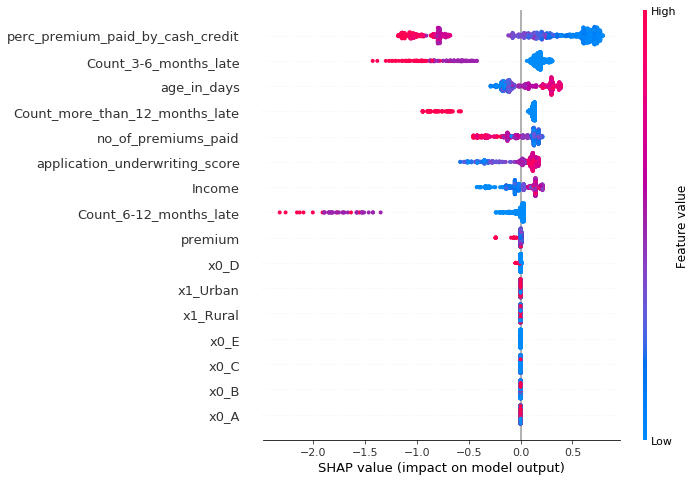

In [160]:
explainer = shap.TreeExplainer(clf)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[0:1000], X_test.iloc[0:1000,:])

<h4> Interpretations :</h4> <br>

We have taken top 10 data points from the test set and tried to predict the renewal and explain the model decision using shap summary plots, following are the observations :

1. If percentange of premium paid by credit means is high the probablity of non-renewal is also high.
<br>

2. If a person has a history of delayed payments, chances of non-renewal also increases. if delay is more than 6-12 month it's almost certain case of non-renewal.
<br>

3. Younger aged people have higher chances of non-renewal.
<br>


<h2>2. Finding Optimal Agents Commission</h2><br><br>

Also, calculated how much money the company should Pay to the agents so that the expected revenue can increase.<br><br>

\begin{equation}
Expected Revenue = P(renewal) * premium - incentive 
\end{equation}

The probablity of renewal increases with incentive given to the agent, given by the equations : <br><br>

\begin{equation}
Efforts=10 * (1-e^{-Incentive/400})
\end{equation}


\begin{equation}
\Delta P = 0.2 * (1-e^{-Efforts/5})
\end{equation}




In [ ]:
def find_prob_using_commision(incentive,p):
    
    '''finds the increase in the probablity of renewal for a given revenue and probablity '''
    
    effort=10*(1-exp(-incentive/400))
    
    del_p=0.2*(1-exp(-effort/5))
    
    # if the probablity is greater than 1
    
    if del_p+p>1:
        
        del_p=1-p
    
    return del_p


def calculate_revenue(p,premium,incentive):
    
    ''' 
      calculates the revenue for premium, incentive and probablity 
      
    '''
    
    return premium*find_prob_using_commision(incentive,p)-incentive


data_=pd.read_csv('/Users/shrutijain/Desktop/ING/opt_comm.csv')

data_=data_.iloc[:,1:]

a=len(data_.index)

for ind in data_.index:
    b=(ind/a)*100
    print(b,"% done ")
    
    data_.loc[ind,'agent_commission']=\
    op.fmin(lambda x: -calculate_revenue(data_.loc[ind,'p'],data_.loc[ind,'premium'],x), 0)



<h2> Final Results </h2>

The optimized values of the agent commision as per the Optimization Algorithm and XGBoost probability is given for all the points in the test sample points :

In [165]:
data_.agent_commission

0         33.900625
1         24.812125
2          0.000000
3          0.000000
4         97.028125
            ...    
15366     62.119750
15367    203.833125
15368    170.210125
15369      0.000000
15370     21.647500
Name: agent_commission, Length: 15371, dtype: float64